In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn import preprocessing

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [27]:
n = 500
g = 3000
k = 30
o = 1
avgGenesInPath = 100

In [28]:
def DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes):
    df = pd.DataFrame(X.T)
    is_gene = np.ones(g)
    is_gene[0] = 0
    phenotype_gene_col = np.zeros(g)
    phenotype_gene_col[phenotypeGenes] = 1
    
    df['is_gene'] = is_gene
    df['phenotype_genes'] = phenotype_gene_col
    
    df = pd.concat([df, pd.DataFrame(binaryPathwayMatrix, columns=['pathway{}'.format(i) for i in range(binaryPathwayMatrix.shape[1])])], axis=1)
    return df

def DFtoDataset(df, scale=False):
    X = df[np.arange(n)].values.T
    if (scale):
        X = preprocessing.scale(X)
        
    binaryPathwayMatrix = df[['pathway{}'.format(i) for i in range(df.shape[1] - n - 2)]].values

    phenotypeGenes = df['phenotype_genes']
    phenotypeGenes = np.where(phenotypeGenes == 1)[0]

    return X, binaryPathwayMatrix, phenotypeGenes

In [50]:
U, V, binaryPathwayMatrix, phenotypeGenes = GenerateSimulatedData(n, g, k, avgGenesInPath, covariateU=True)
X = np.dot(U, V.T)

In [51]:
df = DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes)

In [52]:
X_rec, bin_rec, phe_rec = DFtoDataset(df)

In [53]:
assert np.all(X_rec == X)
assert np.all(np.sort(phe_rec) == np.sort(phenotypeGenes))
assert np.all(bin_rec == binaryPathwayMatrix)

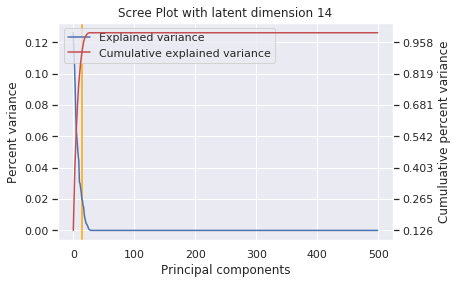

In [54]:
ScreePlot(X.T)

In [55]:
pca = PCA(n_components=50)
projectedX = pca.fit_transform(X.T)
latent_dim = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
latent_dim

17

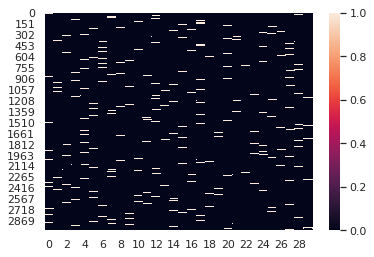

In [56]:
sns.heatmap(binaryPathwayMatrix)

In [57]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsneProjectedX = tsne.fit_transform(projectedX)

In [58]:
inPathway = ['p{}'.format(i) for i in binaryPathwayMatrix[:, 0]]

In [59]:
np.sort(phenotypeGenes)

array([   0,   15,   21,   86,  109,  186,  193,  240,  258,  270,  396,
        444,  475,  481,  495,  503,  527,  531,  575,  580,  612,  660,
        703,  739,  803,  825,  841,  849,  877,  879,  884,  886,  896,
        906,  927,  942,  983,  992, 1056, 1153, 1158, 1198, 1324, 1343,
       1417, 1440, 1496, 1497, 1519, 1521, 1555, 1621, 1623, 1636, 1682,
       1702, 1750, 1758, 1799, 1834, 1838, 1843, 1880, 1905, 1915, 1939,
       1984, 1991, 2030, 2055, 2141, 2162, 2163, 2193, 2271, 2279, 2289,
       2321, 2347, 2366, 2402, 2405, 2422, 2470, 2492, 2500, 2525, 2539,
       2560, 2577, 2605, 2618, 2671, 2672, 2706, 2758, 2788, 2846, 2850,
       2899, 2906, 2992])

In [60]:
geneMat = np.zeros(g) - 1

In [61]:
isInPath = np.sum(binaryPathwayMatrix, axis=1) > 0
geneMat[isInPath] = np.where(binaryPathwayMatrix > 0)[1]

In [62]:
phenotype_gene_col = np.zeros(g)
phenotype_gene_col[phenotypeGenes] = 1
df2 = pd.DataFrame({
    'tsne1': tsneProjectedX[:, 0],
    'tsne2': tsneProjectedX[:, 1],
    'pathway': ['p{}'.format(i) for i in geneMat] #binaryPathwayMatrix[:, 4]]#phenotype_gene_col]
})

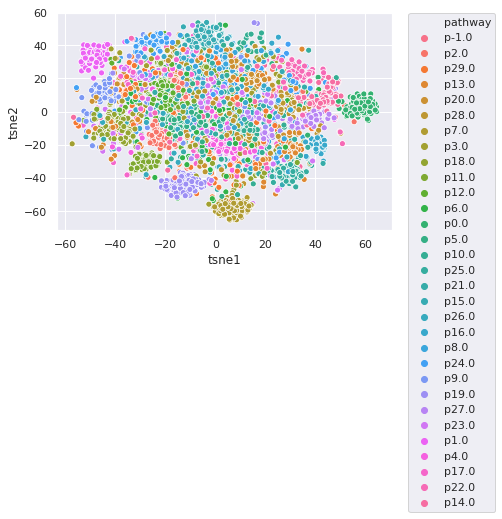

In [63]:
sns.scatterplot(x='tsne1', y='tsne2', hue='pathway', data=df2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [64]:
tsne_V = TSNE(n_components=2)
tsneProjectedV = tsne_V.fit_transform(V)

In [65]:
df3 = pd.DataFrame({
    'tsne1': tsneProjectedV[:, 0],
    'tsne2': tsneProjectedV[:, 1],
    'pathway': ['p{}'.format(i) for i in geneMat] #binaryPathwayMatrix[:, 4]]#phenotype_gene_col]
})

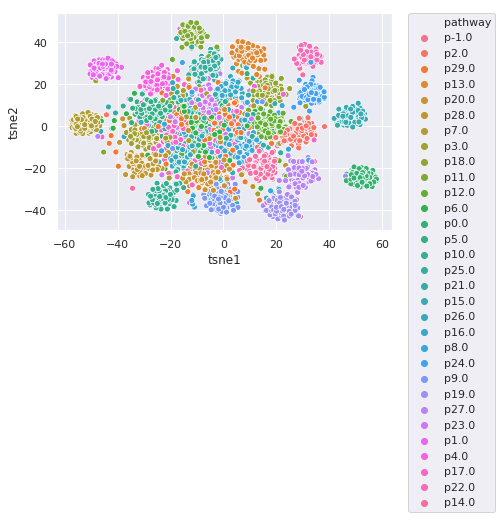

In [66]:
sns.scatterplot(x='tsne1', y='tsne2', hue='pathway', data=df3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

/homes/gws/psturm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


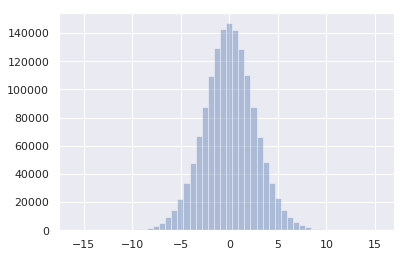

In [67]:
sns.distplot(X.flatten(), kde=False)

In [68]:
for i in range(50):
    U, V, binaryPathwayMatrix, phenotypeGenes = GenerateSimulatedData(n, g, k, avgGenesInPath)
    X = np.dot(U, V.T)
    df = DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes)
    df.to_csv('/projects/leelab2/data/AD_DATA/simulatedData/latentData/df{}.csv'.format(i), index=False)

In [69]:
for i in range(50):
    U, V, binaryPathwayMatrix, phenotypeGenes = GenerateSimulatedData(n, g, k, avgGenesInPath, covariateU=True)
    X = np.dot(U, V.T)
    df = DatasetToDF(X, binaryPathwayMatrix, phenotypeGenes)
    df.to_csv('/projects/leelab2/data/AD_DATA/simulatedData/corLatentData/df{}.csv'.format(i), index=False)